# IoT Challenge - Geolocalization

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from plotly import offline
import folium
import datetime as dt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,7.5)})


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

In [56]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

## Data exploration

In [3]:
# DataFrame containing the GPS Coordinates of all the bases (train and test datasets)

base_pos = pd.concat([df_mess_test, df_mess_train])[["bsid", "bs_lat", "bs_lng"]].drop_duplicates()


# List of bases in the train set whose coordinates are (64.3, -68.5)

bases_wo_coordinates = np.unique(base_pos[base_pos["bs_lat"] == 64.3]["bsid"])


# List of unique messages with at least one reception from the base with 
# outlier coordinates (see later) | (64.3, -68.5)

msg_incl_bs_wo_coord = np.unique(df_mess_train[df_mess_train["bsid"].isin(bases_wo_coordinates)]["messid"])


# Train dataset containing only messages whose attached device sent at least one message to the base with
# outlier coordinates (see later) | (64.3, -68.5)

df_msg_incl_bs_wo_coord = df_mess_train[df_mess_train["messid"].isin(msg_incl_bs_wo_coord)]


# List of all bases in the above dataset: bases of reception for devices that sent at least one message
# to the base with outlier cooridnates (see later) | (64.3, -68.5)

base_pos_msg_sent_to_outlier_bases = df_msg_incl_bs_wo_coord[["bsid", "bs_lat", "bs_lng"]].drop_duplicates()

In [4]:
t0 = dt.datetime.now()

# Barycentre Coordinates
barycentre = [41.822374, -104.039671]

# Sample (0.33% over 1.5 million) 
sample_coords = base_pos[["bs_lat", "bs_lng"]].values

# Build map 
map_bases = folium.Map(location=barycentre, zoom_start=3.2, 
tiles='cartodbpositron', width=640, height=480)

# [ unicode(x.strip()) if x is not None else '' for x in row ]


# Plot coordinates using comprehension list
[folium.CircleMarker(sample_coords[i], radius=1,
                color='red', fill_color='red').add_to(map_bases)
 if np.array_equal(sample_coords[i], [64.3, -68.5])
 else folium.CircleMarker(sample_coords[i], radius=1,
                color='#0080bb', fill_color='#0080bb').add_to(map_bases)
 for i in range(len(sample_coords))]

# Display map in Jupyter
display(map_bases)

===================================================================================================================

Bases are located around Denver in the US. The map allows to identify potential outliers, particularly in the North-East of Canada (GPS Coordinates: 64.3, -68.5)

===================================================================================================================

In [8]:
tmp = df_msg_incl_bs_wo_coord.join(pos_train)
tmp = tmp[["lat", "lng"]]
tmp.drop_duplicates(inplace=True)

t0 = dt.datetime.now()

# Barycentre Coordinates
barycentre = [39.823794, -105.099671]

# Sample (0.33% over 1.5 million) 
sample_coords = tmp.values

# Build map 
map_bases = folium.Map(location=barycentre, zoom_start=9.2, 
tiles='cartodbpositron', width=640, height=480)

# Plot coordinates using comprehension list
[folium.CircleMarker(sample_coords[i], radius=1,
                color='#71ddc0', fill_color='#71ddc0').add_to(map_bases)
 for i in range(len(sample_coords))]

sample_coords = base_pos_msg_sent_to_outlier_bases[["bs_lat", "bs_lng"]].values

# Build map 
[folium.CircleMarker(sample_coords[i], radius=1,
                color='red', fill_color='red').add_to(map_bases)
 if np.array_equal(sample_coords[i], [64.3, -68.5])
 else folium.CircleMarker(sample_coords[i], radius=1,
                color='#0080bb', fill_color='#0080bb').add_to(map_bases)
 for i in range(len(sample_coords))]



# Display map in Jupyter
display(map_bases)

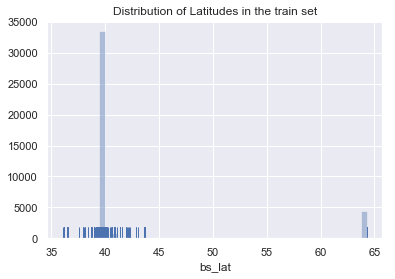

In [9]:
sns.distplot(df_mess_train["bs_lat"], kde=False, rug=True)
plt.title("Distribution of Latitudes in the train set")
plt.show()

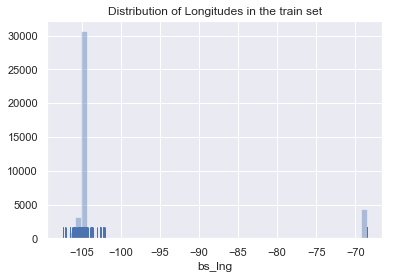

In [10]:
sns.distplot(df_mess_train["bs_lng"], kde=False, rug=True)
plt.title("Distribution of Longitudes in the train set")
plt.show()

In [11]:
df_msg_per_base_train = df_mess_train.groupby(["bs_lat", "bs_lng"]).count().sort_values("bsid", ascending=False).reset_index()[["bs_lat", "bs_lng", "messid"]]
df_msg_per_base_train.columns = ["bs_lat", "bs_lng", "nb_msgs"]
df_msg_per_base_test = df_mess_test.groupby(["bs_lat", "bs_lng"]).count().sort_values("bsid", ascending=False).reset_index()[["bs_lat", "bs_lng", "messid"]]
df_msg_per_base_test.columns = ["bs_lat", "bs_lng", "nb_msgs"]

df_msg_per_base_train.head()

,bs_lat,bs_lng,nb_msgs
0,64.300000,-68.500000,4389
1,39.803795,-105.072090,1128
2,39.817654,-105.050984,1073
3,39.704887,-105.016392,987
4,39.805696,-105.056208,888


In [12]:
print("TRAIN SET | Share of messages sent to base with odd coordinates: {:0.2%}".format(df_msg_per_base_train["nb_msgs"][0] / df_msg_per_base_train.sum()["nb_msgs"]))
print("-----------------------------------------------------------------")

print("TEST SET | Share of messages sent to base with odd coordinates: {:0.2%}".format(df_msg_per_base_test["nb_msgs"][0] / df_msg_per_base_test.sum()["nb_msgs"]))
print("-----------------------------------------------------------------")
print("Number of bases with 'outlier' coordinates: " + str(bases_wo_coordinates.shape[0]))

TRAIN SET | Share of messages sent to base with odd coordinates: 11.18%
-----------------------------------------------------------------
TEST SET | Share of messages sent to base with odd coordinates: 10.48%
-----------------------------------------------------------------
Number of bases with 'outlier' coordinates: 29


In [13]:
def base_categorization(row):
    return (row["bs_lat"] == 64.3) * 1

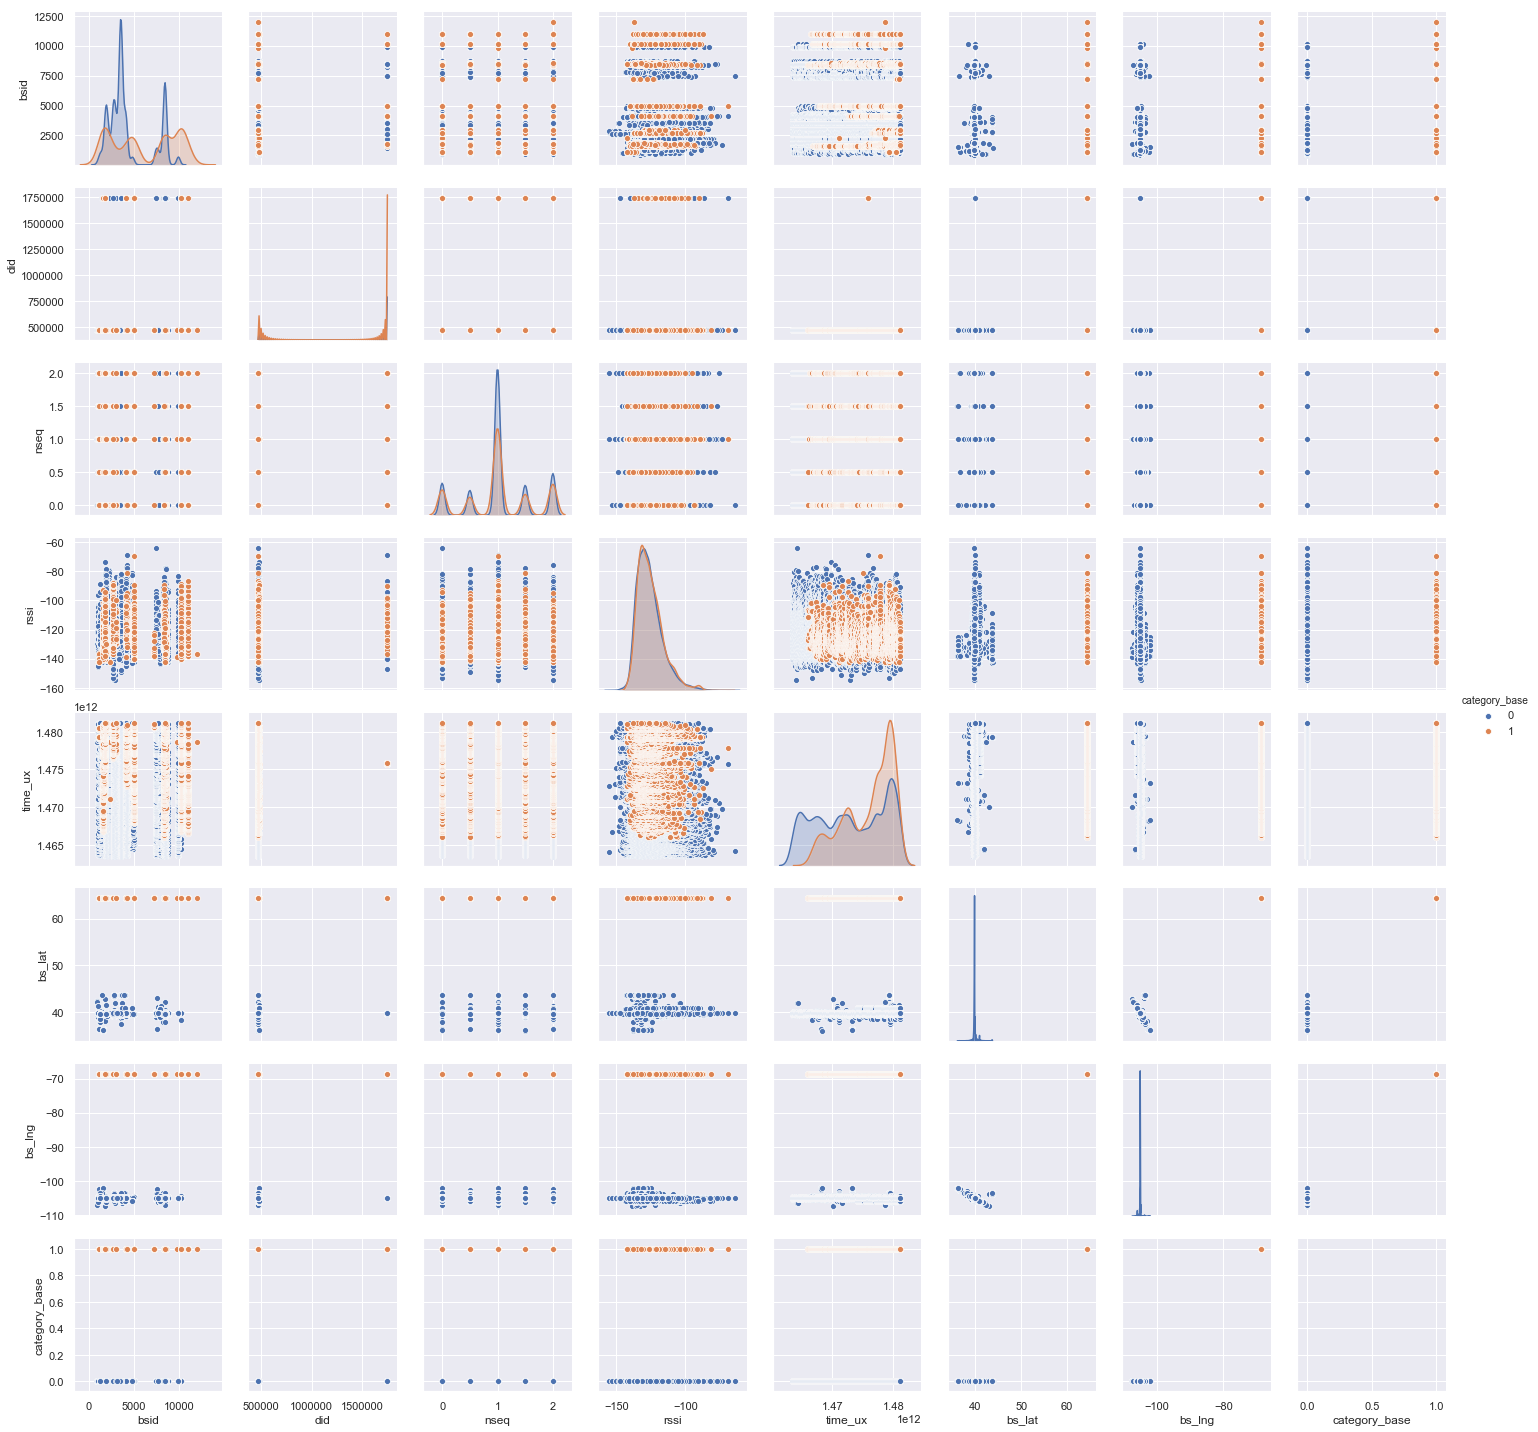

In [14]:
df_mess_train["category_base"] = df_mess_train.apply(base_categorization, axis=1)

sns.pairplot(df_mess_train, hue="category_base")
plt.show()

===================================================================================================================

Bases located at (GPS Coordinates: 64.3, -68.5) represent a signficiant share of data points: ~10% on the whole dataset. Analysing the pairplot graph above shows no differences in data (including rssi) apart from the GPS location, confirming a recording error

===================================================================================================================

## Outliers processing I

Following our realization of outlier bases with geolocalization positions that do not seem to make sense, we decided to compute, approximatelly, their longitude and latitude by using the coordinates of the (weighted) centroid of the messages each outlier base received.

The code coded provided below did this cleaning

In [15]:
# List of unique messages
listOfmess = np.unique(df_mess_train['messid'])

# DataFrame with all training_data, including positions
df = pd.concat([df_mess_train, pos_train], axis=1)

In [16]:
# We can notice that the outlier bases have latitude at 64.3 and longitude at -68.5:
df.groupby(['bsid']).mean()[['bs_lat', 'bs_lng']].sort_values(['bs_lat'], ascending=False).head(10)

,bs_lat,bs_lng
bsid,,
1772,64.3,-68.5
4156,64.3,-68.5
8560,64.3,-68.5
2943,64.3,-68.5
8449,64.3,-68.5
4987,64.3,-68.5
11951,64.3,-68.5
2293,64.3,-68.5
7248,64.3,-68.5


In [17]:
# Selecting these bases
bases_out = df[(df['bs_lat']==64.3) & (df['bs_lng']==-68.5)]['bsid'].unique()
bases_out

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  2293,
        4959, 10999,  1661,  8449,  4156,  4129,  1743,  4987,  1772,
        1796,  2707,  2943,  4123, 11951,  9784,  1092,  1854,  7248])

In [61]:
# Method that approximates position of outlier bases to the weighted centroid of the messages they received

def correct_bases_pos(bases_out, df_mess_train, df_mess_test, pos_train):
    
    # Concatenate positions and df_mess_train
    df = pd.concat([df_mess_train, pos_train], axis=1)
    
    # Getting dataframe with all data for the oulier bases
    df_out = df[df['bsid'].isin(bases_out)]

    # Initiating arrays that will have the lat, long and rssi of messages received by the bases, 
    # Each column represents a message
    mess_num = len(listOfmess) # number of messages
    lat_array = np.zeros((df_out.shape[0], mess_num))
    lng_array = np.zeros((df_out.shape[0], mess_num))
    weight_array = np.zeros((df_out.shape[0], mess_num)) # weights to be used: sqrt(exp(rssi))
    
    # Dictionary to track message id and corresponding column in array
    mess_dict = {}
    for i, column in enumerate(listOfmess):
        mess_dict[column] = i
    
    # assigning values to arrays
    for i, ix in enumerate(df_out.index):
        mess = df_out.loc[ix, 'messid']
        column = mess_dict[mess]
    
        # Using sqrt(exp(rssi)) as weight to get weighted centroid
        weight_array[i, column] = np.sqrt(np.exp(df_out.loc[ix, 'rssi']))
        weight = np.sqrt(np.exp(df_out.loc[ix, 'rssi']))
        lat_array[i, column] = df_out.loc[ix, 'lat'] * weight
        lng_array[i, column] = df_out.loc[ix, 'lng'] * weight
    
    # Transforming arrays in dataframe in order to use groupby()
    lat_df = pd.DataFrame(lat_array)
    lng_df = pd.DataFrame(lng_array)
    weight_df = pd.DataFrame(weight_array)

    # Adding column bsid for each dataframes in order to perform groupby()
    lat_df['bsid'] = lng_df['bsid'] = weight_df['bsid'] = df_out.reset_index()['bsid']

    # Grouping and suming --- Note that values for lat and lng are already weighted
    lat_df_grouped = lat_df.groupby('bsid').sum()
    lng_df_grouped = lng_df.groupby('bsid').sum()
    weight_df_grouped = weight_df.groupby('bsid').sum()

    # Dividing each row by the sum of the weights for the respective row
    lat_df_grouped = lat_df_grouped.divide(weight_df_grouped.sum(axis=1), axis=0)
    lng_df_grouped = lng_df_grouped.divide(weight_df_grouped.sum(axis=1), axis=0)

    # Getting the final weighted latitudes and longitudes
    lat_out = lat_df_grouped.sum(axis=1)
    lng_out = lng_df_grouped.sum(axis=1)

    # Assigning these new latitudes and longitudes to the bases in the test and training sets
    for base in lat_out.index:
        df_mess_train.loc[df_mess_train['bsid']==base, 'bs_lat'] = lat_out.loc[base]
        df_mess_train.loc[df_mess_train['bsid']==base, 'bs_lng'] = lng_out.loc[base]
    
        df_mess_test.loc[df_mess_test['bsid']==base, 'bs_lat'] = lat_out.loc[base]
        df_mess_test.loc[df_mess_test['bsid']==base, 'bs_lng'] = lng_out.loc[base]

In [62]:
# Running method
correct_bases_pos(bases_out, df_mess_train, df_mess_test, pos_train)

## Features Engineering

### "One Hot encoding" of the data

**NB: the different steps of our feature engineering reflexion are presented below, the function that builds our final feature matrix is defined at the end of this section.**


- A first step was to "encode" (transform) the data as the following: as a single 'messid' is represented several times in the data (for each base station that received its signal), we decided to keep only one row for each messid, having columns corresponding to the base stations that received its signal: this is 'one-hot encoding'

Then 

- We decided to go further than simple "one-hot encoding" of base stations and created encoded features using the following: latitude, longitude, rssi, nseq. This means we have now for each base station several columns: its latitude, longitude, rssi and nseq.

In [19]:
## One-hot encoding of base stations
# Train test
train_base_station = np.unique(df_mess_train['bsid'])
# Test set
test_base_station = np.unique(df_mess_test['bsid'])

# Columns of base stations in test set
data_baseid = pd.get_dummies(df_mess_test['bsid'])

# Adding columns of base stations in train set that are not in test set
for base in train_base_station :
    if base not in test_base_station:
        new_col = pd.DataFrame(np.zeros(data_baseid.shape[0]))
        new_col.columns = [base]
        data_baseid = pd.concat([data_baseid, new_col], axis=1)

## Definition of new feature columns
# Create and name base long, lat, rssi and nseq columns
newcolumns_lat = {col : "lat_"+str(col) for col in data_baseid.columns}
newcolumns_lng = {col : "lng_"+str(col) for col in data_baseid.columns}
newcolumns_rssi = {col : "rssi_"+str(col) for col in data_baseid.columns}
newcolumns_nseq = {col : "nseq_"+str(col) for col in data_baseid.columns}

# Renaming columns
data_baseid = data_baseid.astype('int')
data_latid = data_baseid.rename(columns=newcolumns_lat)
data_lngid = data_baseid.rename(columns=newcolumns_lng)
data_rssi = data_baseid.rename(columns=newcolumns_rssi)
data_nseq = data_baseid.rename(columns=newcolumns_nseq)

# Creating new features
for col in data_lngid.columns :
    data_lngid[col] = data_lngid[col]*df_mess_train['bs_lng']

for col in data_latid.columns :
    data_latid[col] = data_latid[col]*df_mess_train['bs_lat']

for col in data_rssi.columns :
    data_rssi[col] = data_rssi[col]*df_mess_train['rssi']

for col in data_nseq.columns :
    data_nseq[col] = data_nseq[col]*df_mess_train['nseq']

## Concatenation in one dataset
new_df = df_mess_train['messid']
new_df = pd.concat([new_df, data_latid, data_lngid, data_rssi,  data_nseq], axis=1)

## Using groupby() to keep only one row per messid and getting final dataFrame of features
df_feat = new_df.groupby('messid').agg('sum')

### New features

#### Centroid of base stations

Then we decided to build a new feature: the centroid (latitude and longitude) of the base stations. 

Indeed, as shown below, as a message is received by one or more base station, there is great probability that it would be located next to the centroid of the base stations that received its signal

In [20]:
# Function that plots the location of base stations and their centroid of a given message
def plot_bases(message_index):
    base_lat = [x for x in df_feat[list(newcolumns_lat.values())].iloc[message_index] if x!=0]
    base_lng = [x for x in df_feat[list(newcolumns_lng.values())].iloc[message_index] if x!=0]
    plt.plot(base_lng, base_lat, 'ob', label='Base stations')
    plt.plot(np.mean(base_lng), np.mean(base_lat), 'or', label="Centroid")
    plt.title('Centroid of Base Stations that received message :\n " {} " '.format(df_feat.index[message_index]))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

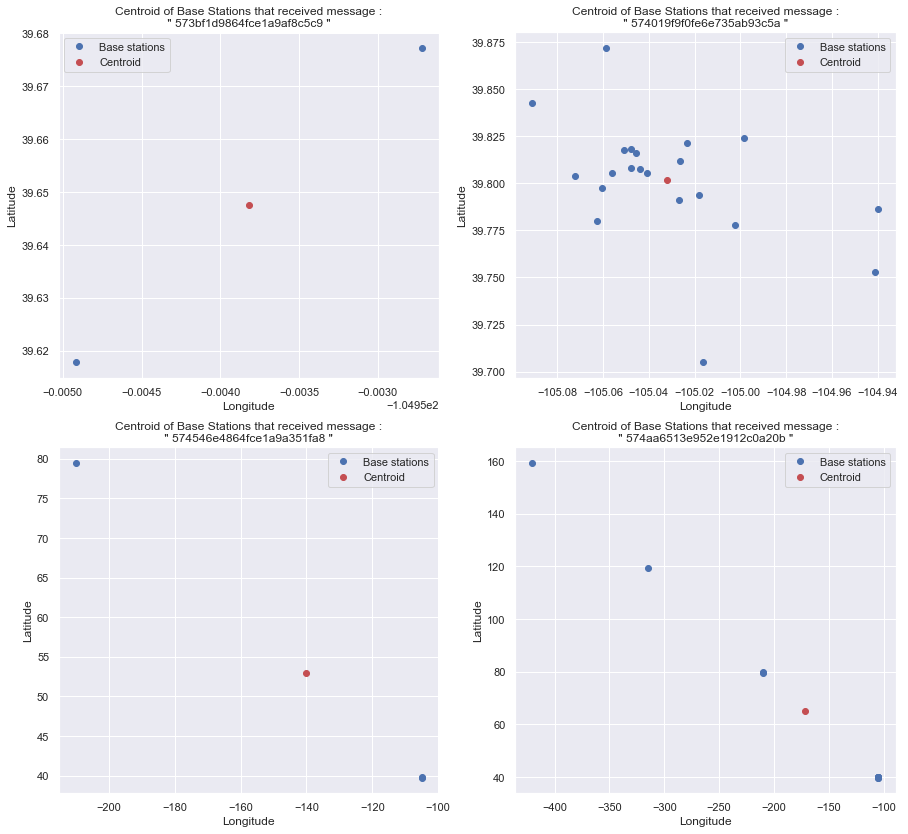

In [21]:
# Plot of the location of base stations and their centroid for a few message
plt.figure(figsize=(15,14))

for i in range(4):
    plt.subplot(221+i)
    plot_bases((i+5)*(10*i))
    plt.legend()

plt.show()

In [22]:
# Definition of centroid of latitude and longitude of base stations for each message
centroid_bs_lat = []
centroid_bs_lng = []

for i in range(df_feat.shape[0]):
    base_lat = [x for x in df_feat[list(newcolumns_lat.values())].iloc[i] if x!=0]
    base_lng = [x for x in df_feat[list(newcolumns_lng.values())].iloc[i] if x!=0]
    centroid_bs_lat.append(np.mean(base_lat))
    centroid_bs_lng.append(np.mean(base_lng))

In [23]:
df_feat["centroid_bs_lat"] = centroid_bs_lat
df_feat["centroid_bs_lng"] = centroid_bs_lng

#### Transformation of rssi

It has been scientifically proved that the power of an electromagnetic wave decreases with the distance it travels.
Actually, a coefficient of attenuation applies to this power and is exponentially related to the square of the distance the wave travels.

The feature rssi being the measure of the power of the signal measured by the base station (rssi = 1/10 * log(Signal Power)),  when plotting the rssi vs. the distance between the position of the device and the base station that received its message, we should see an exponential decreasing trend (at square scale)

The plot below reveals this very trend. It can be noticed that all the points do not "fit" with the trend and are not the same from the device to another: it might be due to :
- obstacles encountered by the message during its travel
- difference of nominal power between devices

In [22]:
 ### Plot @Théo

Despite the potential perturbations in the signal travel, we decided to transform the variable 'rssi' applying the square root of its exponential. This transformed feature should be representative of the distance the wave travelled (putting aside perturbations)

In [24]:
# Creating new_rssi columns
df_mess_train['new_rssi'] = np.sqrt(np.exp(df_mess_train['rssi'] ))

newcolumns_newrssi = {col: "new_rssi_"+str(col) for col in data_baseid.columns}
data_new_rssi = data_baseid.rename(columns=newcolumns_newrssi)

for col in data_new_rssi.columns :
    data_new_rssi[col] = data_new_rssi[col]*df_mess_train['new_rssi']

# Rebuilding the feature dataframe 
new_df = df_mess_train['messid']
new_df = pd.concat([new_df, data_latid, data_lngid, data_rssi, data_new_rssi, data_nseq], axis=1)

## Grouping by messid
df_feat = new_df.groupby('messid').agg('sum')
df_feat["centroid_bs_lat"] = centroid_bs_lat
df_feat["centroid_bs_lng"] = centroid_bs_lng

#### Rssi-weighted centroid of base station

Having now a feature that should reflect the distance between the base station and where the message received was emitted, we thought it would be worth it trying to build a new feature: the weigthed centroids of base stations using the new feature previously created.

Indeed the closer the message is to a station, the more this station should count in the computation of the centroids of stations.

In [27]:
## Computation of the weighted centroid of base stations
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid']))
bases_num = len(listOfBs)

bases_dict = {}
for i, column in enumerate(listOfBs):
    bases_dict[column] = i

lat_array = np.zeros((df_mess_train.shape[0], bases_num))
lng_array = np.zeros((df_mess_train.shape[0], bases_num))
weights_array = np.zeros((df_mess_train.shape[0], bases_num))

for i in df_mess_train.index:
    # getting bsid for current row
    bsid = df_mess_train.loc[i, 'bsid']
    # getting colum to assign value in bases_array
    column = bases_dict[bsid]
    # assigning weight (sqrt(rssi)) value to cell in bases array
    weight = np.exp(df_mess_train.loc[i, 'rssi'])**(1/2)
    lat_array[i, column] = weight * df_mess_train.loc[i, 'bs_lat']
    lng_array[i, column] = weight * df_mess_train.loc[i, 'bs_lng']
    weights_array[i, column] = weight

# Transforming data arrays into dataframes
lat_df = pd.DataFrame(lat_array)
lng_df = pd.DataFrame(lng_array)
weights_df = pd.DataFrame(weights_array)
# Adding messid column to each data-frame (lat, lng and weights)
lat_df['messid'] = df_mess_train['messid']
lng_df['messid'] = df_mess_train['messid']
weights_df['messid'] = df_mess_train['messid']

#Grouping
lat = lat_df.groupby('messid').sum().sum(axis=1)
lng = lng_df.groupby('messid').sum().sum(axis=1)
weights = weights_df.groupby('messid').sum().sum(axis=1)

# Normalizing by sum of weights
df_weight = pd.DataFrame([lat, lng], index=['lat','lng'])
df_weight = (df_weight/weights).T

The plot below help picture the changes between the new weighted centroid and the previous one 

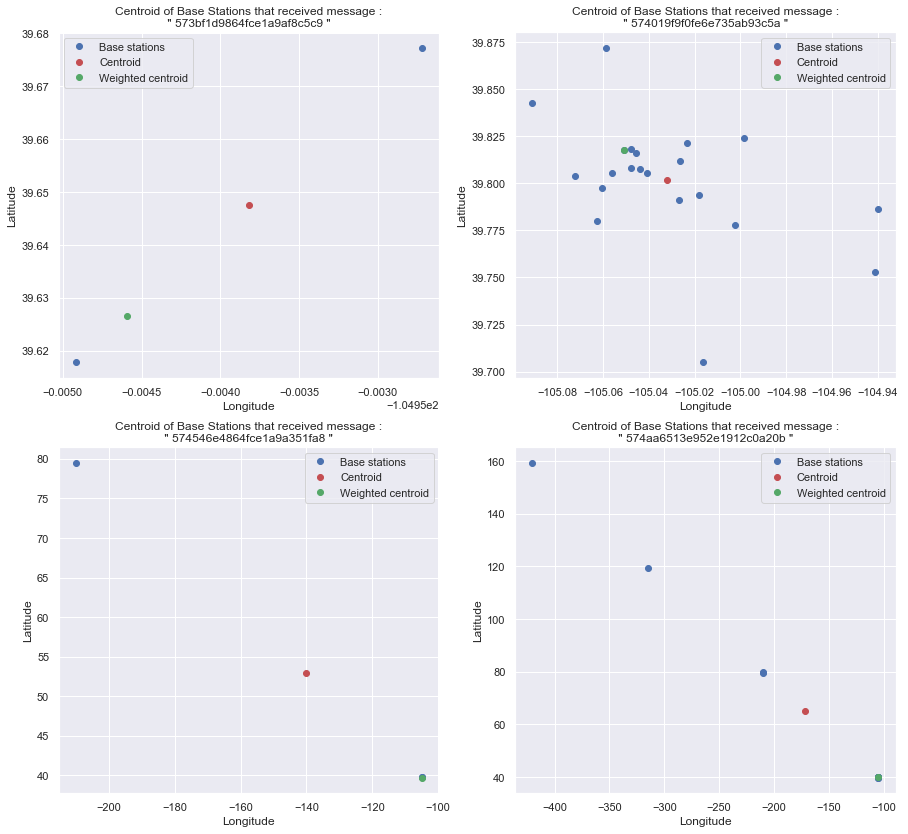

In [28]:
# Plot of the location of base stations and their centroid for a few message
plt.figure(figsize=(15,14))

for i in range(4):
    plt.subplot(221+i)
    plot_bases((i+5)*(10*i))
    plt.plot(df_weight['lng'].iloc[(i+5)*(10*i)], df_weight['lat'].iloc[(i+5)*(10*i)], 'og', label='Weighted centroid')
    plt.legend()
plt.show()

#### Definition of final feature matrix

Once we created the features mentionned above, we tested with cross validation the performance of different models on different combination of the features:
- all together
- all together without weighted centroid
- all together without "normal" centroid
- "normal" centroid only
- weighted centroid only

Ultimately, it appeared the combination of features that provided us with the best performance score was the last one: when using only weighted centroids of latitude and longitude.
Fortunately, this helps reduce the dimension of the feature matrix, hence the computation time when training and testing our algorithms for best model selection.

**Below is the function that builds the feature matrix we will use for the rest of the project**

In [30]:
# Final feature matrix function that only builds the features we want to keep

def feat_mat_const_centroid(df_mess_train, listOfBs):
    ''' 
    Method used for creation of features. It uses numpy for calculations due to optimization issues
    
    Parameters
    ----------
    df_mess_train: raw dataFrame with input data
    listOfBs: list of unique bases present in both train and test sets
    
    Returns
    -------
    df_feat: modified dataFrame with created features: longitude and latitude of the (weighted) 
    centroid of the bases that detected each message
    '''
    
    bases_num = len(listOfBs)
    
    # One-hot encoding of the data: from rows to columns
    
    # Dictionnary that will track the column in the numpy array and its correpondent base 
    bases_dict = {}
    for i, column in enumerate(listOfBs):
        bases_dict[column] = i
    
    
    # Creating array to be transformed at feature matrix (columns = features)
    lat_array = np.zeros((df_mess_train.shape[0], bases_num))
    lng_array = np.zeros((df_mess_train.shape[0], bases_num))
    weights_array = np.zeros((df_mess_train.shape[0], bases_num))
    
    # assigning values for new features
    for i in df_mess_train.index:
        # getting bsid for current row
        bsid = df_mess_train.loc[i, 'bsid']
        # getting colum to assign value in bases_array
        column = bases_dict[bsid]
        # assigning weight (sqrt(rssi)) value to cell in bases array
        weight = np.exp(df_mess_train.loc[i, 'rssi'])**(1/2)
        lat_array[i, column] = weight * df_mess_train.loc[i, 'bs_lat']
        lng_array[i, column] = weight * df_mess_train.loc[i, 'bs_lng']
        weights_array[i, column] = weight
    
    # Tranforming bases_array to dataFrame in order to use .groupby()

    lat_df = pd.DataFrame(lat_array)
    lng_df = pd.DataFrame(lng_array)
    weights_df = pd.DataFrame(weights_array)
    
    
    # Using groupby() and getting final dataFrame of features
    
    # Adding messid column to each data-frame (lat, lng and weights)
    lat_df['messid'] = df_mess_train['messid']
    lng_df['messid'] = df_mess_train['messid']
    weights_df['messid'] = df_mess_train['messid']
    
    lat = lat_df.groupby('messid').sum().sum(axis=1)
    lng = lng_df.groupby('messid').sum().sum(axis=1)
    weights = weights_df.groupby('messid').sum().sum(axis=1)
    
    # Normalizing
    df_feat = pd.DataFrame([lat, lng], index=['lat','lng'])
    df_feat = (df_feat/weights).T
    
    return df_feat

In [57]:
# Creating DataFrame with final features
df_feat = feat_mat_const_centroid(df_mess_train, listOfBs)

#### Ground Truth Building

In [39]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [53]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

## Model

### Evaluation functions

We defined below the functions that will aid us to evaluate our models

In [41]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

### First model and predictions

Following the preprocessing of ouliers bases and the features engineering we can check the first results by running a first model on the dataset.

We compute the precision of our predictions with leave-one-device-out Cross-Validation

In [59]:
# Defining first model

def regressor_and_predict_devices_RF_base(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    '''
    Train regressor and make prediction in the train set
    Input: df_feat: feature matrix used to train regressor
           ground_truth_lat: df_feat associated latitude
           ground_truth_lng: df_feat associated longitude
           df_test: data frame used for prediction
    Output: y_pred_lat, y_pred_lng
    '''
    
    X = df_feat
    y_lat = ground_truth_lat
    y_lng = ground_truth_lng
    
    model = RandomForestRegressor(max_depth=600, n_estimators=50, n_jobs=-1)
    model.fit(X, np.array([y_lat, y_lng]).T)
    y_pred_lat, y_pred_lng = model.predict(df_test).T
    
    return y_pred_lat, y_pred_lng

Running first model with leave-one-device-out CV and keeping devices that were predicted far from their ground truth position to investigate:

In [66]:
# Getting devices
devices = np.unique(df_mess_train.did).astype('int64')
n_devices_train = len(np.unique(df_mess_train.did))
n_devices_test = len(np.unique(df_mess_test.did))

percentiles = []

kf = KFold(n_splits=n_devices_train, shuffle=False, random_state=0)

devices_out = []
devices_far = set([])

k_fold_perc = []
for step, (train_index, test_index) in enumerate(kf.split(devices)):

    train_devices = devices[train_index]
    test_devices = devices[test_index]
    devices_out.append(test_devices[0])

    mess_train = df_mess_train[df_mess_train.did.isin(
        train_devices)].messid.unique()
    mess_test = df_mess_train[df_mess_train.did.isin(
        test_devices)].messid.unique()

    X_train = df_feat.loc[mess_train]
    X_test = df_feat.loc[mess_test]

    lat_train, lng_train = (ground_truth_lat[df_feat.index.isin(mess_train)],
                            ground_truth_lng[df_feat.index.isin(mess_train)])
    lat_test, lng_test = (ground_truth_lat[df_feat.index.isin(mess_test)],
                          ground_truth_lng[df_feat.index.isin(mess_test)])

    # Compute predictions
    y_pred_lat, y_pred_lng = regressor_and_predict_devices_RF_base(
        X_train, lat_train, lng_train, X_test)

    err = Eval_geoloc(lat_test, lng_test, y_pred_lat, y_pred_lng)
    percentile = np.percentile(err, 80)
    k_fold_perc.append(percentile)
    if(percentile > 10000):
        devices_far.add(test_devices[0])
    print(f"Crossvalidation step {step}.. device {test_devices[0]}.. percentile: {percentile:.2f}")

# At the end, we look at the average error upon all the devices.
mean_perc = np.array(k_fold_perc).mean()
print("-----------------------------------------------------")
print(f"Percentile mean: {mean_perc:.2f}")
print("-----------------------------------------------------\n")

Crossvalidation step 0.. device 473288.. percentile: 133500.57
Crossvalidation step 1.. device 473335.. percentile: 5465.95
Crossvalidation step 2.. device 473368.. percentile: 3479.83
Crossvalidation step 3.. device 473401.. percentile: 3079.09
Crossvalidation step 4.. device 473438.. percentile: 4947.19
Crossvalidation step 5.. device 473502.. percentile: 1342.60
Crossvalidation step 6.. device 473507.. percentile: 4984.02
Crossvalidation step 7.. device 473512.. percentile: 3905.77
Crossvalidation step 8.. device 473683.. percentile: 3447.32
Crossvalidation step 9.. device 473796.. percentile: 7263.92
Crossvalidation step 10.. device 473805.. percentile: 4940.27
Crossvalidation step 11.. device 473864.. percentile: 4109.14
Crossvalidation step 12.. device 473871.. percentile: 3982.85
Crossvalidation step 13.. device 473892.. percentile: 4535.24
Crossvalidation step 14.. device 473897.. percentile: 9704.69
Crossvalidation step 15.. device 473899.. percentile: 3491.21
Crossvalidation 

#### Visualizing bad predictions

In [67]:
# List of devices with bad predictions
devices_far

{473288, 476248, 476256, 476598, 476889, 476896}

If we take a closer look at the bases that dected some of these devices we found an interesting caracteristic:

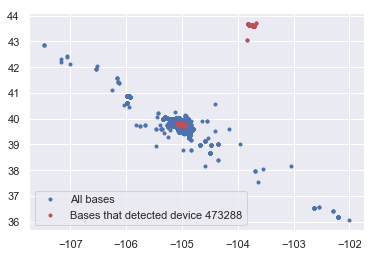

In [90]:
lat_bad = df_mess_train[df_mess_train.did == 473288].bs_lat
lng_bad = df_mess_train[df_mess_train.did == 473288].bs_lng

plt.plot(df_mess_train.bs_lng, df_mess_train.bs_lat, color='b', marker='.', linestyle='None', label='All bases')
plt.plot(lng_bad, lat_bad, color='r', marker='.', linestyle='None', label='Bases that detected device 473288')
plt.legend();

We can see that some bases that detected the device 473288 do not follow the same distribution as all the other bases. Once can imagine that these bases are also outliers.

In [94]:
# Choosing these bases:
bases_out = df[(df['bs_lat']>42) & (df['bs_lng']>-104)]['bsid'].unique()
lat_bases_out = df_mess_train[df_mess_train.bsid.isin(bases_out)].bs_lat
lng_bases_out = df_mess_train[df_mess_train.bsid.isin(bases_out)].bs_lng

# Positions of messages detected by these bases
lat_pos_out = pos_train[df_mess_train.bsid.isin(bases_out)].lat
lng_pos_out = pos_train[df_mess_train.bsid.isin(bases_out)].lng

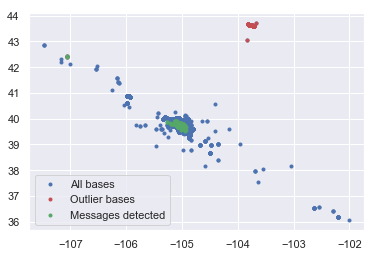

In [95]:
# Plotting bases and the messages detected by these outlier bases
plt.plot(df_mess_train.bs_lng, df_mess_train.bs_lat, color='b', marker='.', linestyle='None', label='All bases')
plt.plot(lng_bases_out, lat_bases_out, color='r', marker='.', linestyle='None', label='Outlier bases')
plt.plot(lng_pos_out, lat_pos_out, color='g', marker='.', linestyle='None', label='Messages detected')
plt.legend();

This plot shows us that these bases do not seem to have the correct positions, as they detect messages far away from them, while closer bases do not detect these messages.

#### Outliers processing II

Following this analysis we runned a second cleaning of the bases, using the same methodology as before:

In [96]:
# Processing of outliers
correct_bases_pos(bases_out, df_mess_train, df_mess_test, pos_train)

# Rebuilding dataframe of features
df_feat = feat_mat_const_centroid(df_mess_train, listOfBs)

#### Evaluating predictions after 2nd processing

In [97]:
percentiles = []

kf = KFold(n_splits=n_devices_train, shuffle=False, random_state=0)

devices_out = []
devices_far = set([])

k_fold_perc = []
for step, (train_index, test_index) in enumerate(kf.split(devices)):

    train_devices = devices[train_index]
    test_devices = devices[test_index]
    devices_out.append(test_devices[0])

    mess_train = df_mess_train[df_mess_train.did.isin(
        train_devices)].messid.unique()
    mess_test = df_mess_train[df_mess_train.did.isin(
        test_devices)].messid.unique()

    X_train = df_feat.loc[mess_train]
    X_test = df_feat.loc[mess_test]

    lat_train, lng_train = (ground_truth_lat[df_feat.index.isin(mess_train)],
                            ground_truth_lng[df_feat.index.isin(mess_train)])
    lat_test, lng_test = (ground_truth_lat[df_feat.index.isin(mess_test)],
                          ground_truth_lng[df_feat.index.isin(mess_test)])

    # Compute predictions
    y_pred_lat, y_pred_lng = regressor_and_predict_devices_RF_base(
        X_train, lat_train, lng_train, X_test)

    err = Eval_geoloc(lat_test, lng_test, y_pred_lat, y_pred_lng)
    percentile = np.percentile(err, 80)
    k_fold_perc.append(percentile)
    if(percentile > 10000):
        devices_far.add(test_devices[0])
    print(f"Crossvalidation step {step}.. device {test_devices[0]}.. percentile: {percentile:.2f}")

# At the end, we look at the average error upon all the devices.
mean_perc = np.array(k_fold_perc).mean()
print("-----------------------------------------------------")
print(f"Percentile mean: {mean_perc:.2f}")
print("-----------------------------------------------------\n")

Crossvalidation step 0.. device 473288.. percentile: 5406.98
Crossvalidation step 1.. device 473335.. percentile: 4962.15
Crossvalidation step 2.. device 473368.. percentile: 2428.98
Crossvalidation step 3.. device 473401.. percentile: 3507.13
Crossvalidation step 4.. device 473438.. percentile: 5498.71
Crossvalidation step 5.. device 473502.. percentile: 1145.57
Crossvalidation step 6.. device 473507.. percentile: 3441.76
Crossvalidation step 7.. device 473512.. percentile: 2960.70
Crossvalidation step 8.. device 473683.. percentile: 2417.90
Crossvalidation step 9.. device 473796.. percentile: 4783.26
Crossvalidation step 10.. device 473805.. percentile: 4881.49
Crossvalidation step 11.. device 473864.. percentile: 3911.72
Crossvalidation step 12.. device 473871.. percentile: 1394.67
Crossvalidation step 13.. device 473892.. percentile: 2072.94
Crossvalidation step 14.. device 473897.. percentile: 10060.99
Crossvalidation step 15.. device 473899.. percentile: 2480.00
Crossvalidation s

We can notice a huge improvement (the percentile reduced by 28%) after dealing with these last outliers

### Model selection & Fine-tunning 

We built 3 models to train on our preprocessed data :

   - Random Forest Regressor
   - Extra Tree Regressor
   - XGBoost Regressor (gradient boosting tree)
   
The methods defined below allowed us to fine-tune the models using Leave-One-Device-Out Cross-Validation

In [99]:
def regressor_and_predict_devices_RF(df_feat, ground_truth_lat, ground_truth_lng, df_test, **kwargs):
    '''
    Train regressor and make prediction in the train set
    Input: df_feat: feature matrix used to train regressor
           ground_truth_lat: df_feat associated latitude
           ground_truth_lng: df_feat associated longitude
           df_test: data frame used for prediction
    Output: y_pred_lat, y_pred_lng
    '''
    
    X = df_feat
    y_lat = ground_truth_lat
    y_lng = ground_truth_lng
    
    model = RandomForestRegressor(**kwargs)
    model.fit(X, np.array([y_lat, y_lng]).T)
    y_pred_lat, y_pred_lng = model.predict(df_test).T
    
    return y_pred_lat, y_pred_lng

In [100]:
def regressor_and_predict_devices_XtraTree(df_feat, ground_truth_lat, ground_truth_lng, df_test, **kwargs):
    '''
    Train regressor and make prediction in the train set
    Input: df_feat: feature matrix used to train regressor
           ground_truth_lat: df_feat associated latitude
           ground_truth_lng: df_feat associated longitude
           df_test: data frame used for prediction
    Output: y_pred_lat, y_pred_lng
    '''
    
    X = df_feat
    y_lat = ground_truth_lat
    y_lng = ground_truth_lng
    
    model = ExtraTreesRegressor(**kwargs)
    
    model.fit(X, np.array([y_lat, y_lng]).T)
    y_pred_lat, y_pred_lng = model.predict(df_test).T
    
    return y_pred_lat, y_pred_lng

In [101]:
def regressor_and_predict_devices_xgb_lat(df_feat, ground_truth_lat, df_test, **kwargs):
    '''
    Train regressor and make prediction in the train set
    Input: df_feat: feature matrix used to train regressor
           ground_truth_lat: df_feat associated latitude
           df_test: data frame used for prediction
    Output: y_pred_lat, y_pred_lng
    '''
    
    X = df_feat
    y_lat = ground_truth_lat

    model = xgb.XGBRegressor(**kwargs)
    model.fit(X, np.array([y_lat]).T)
    y_pred_lat = model.predict(df_test).T
        
    return y_pred_lat



def regressor_and_predict_devices_xgb_lng(df_feat, ground_truth_lng, df_test, **kwargs):
    '''
    Train regressor and make prediction in the train set
    Input: df_feat: feature matrix used to train regressor
           ground_truth_lng: df_feat associated longitude
           df_test: data frame used for prediction
    Output: y_pred_lat, y_pred_lng
    '''
    
    X = df_feat
    y_lng = ground_truth_lng

    model = xgb.XGBRegressor(**kwargs)
    model.fit(X, np.array([y_lng]).T)
    y_pred_lng = model.predict(df_test).T
       
    return y_pred_lng

#### In order to select the best parameters for our models, we trained them during a KFold leave-one-device-out validation

In [102]:
# As an example, here we train our XGBoost regressor for several max_depth of the base estimators.

# Getting devices
devices = np.unique(df_mess_train.did).astype('int64')
n_devices_train = len(np.unique(df_mess_train.did))
n_devices_test = len(np.unique(df_mess_test.did))

# Hyperparameter to be tunned -> max_depth
param_name = "max_depth"
params_list = [5, 8, 15]

percentiles = []

kf = KFold(n_splits=n_devices_train, shuffle=False, random_state=0)

devices_out = []
devices_far = set([])

for i, param in enumerate(params_list):
    k_fold_perc = []
    for step, (train_index, test_index) in enumerate(kf.split(devices)):
        
        train_devices = devices[train_index]
        test_devices = devices[test_index]
        devices_out.append(test_devices[0])
        
        mess_train = df_mess_train[df_mess_train.did.isin(train_devices)].messid.unique()
        mess_test = df_mess_train[df_mess_train.did.isin(test_devices)].messid.unique()

        X_train = df_feat.loc[mess_train]
        X_test = df_feat.loc[mess_test]
        
        lat_train, lng_train = (ground_truth_lat[df_feat.index.isin(mess_train)], 
                                ground_truth_lng[df_feat.index.isin(mess_train)])
        lat_test, lng_test = (ground_truth_lat[df_feat.index.isin(mess_test)],
                              ground_truth_lng[df_feat.index.isin(mess_test)])

        
        y_pred_lat = regressor_and_predict_devices_xgb_lat(X_train, lat_train, X_test, 
                                                               **{param_name: param})
        y_pred_lng = regressor_and_predict_devices_xgb_lng(X_train, lng_train, X_test, 
                                                               **{param_name: param})
        
        # Computing errors
        err = Eval_geoloc(lat_test, lng_test, y_pred_lat, y_pred_lng)
        # 80%-percentile for these errors
        percentile = np.percentile(err, 80)
        # Append it to list of k-fold percentile
        k_fold_perc.append(percentile)
        if(percentile > 10000):
            devices_far.add(test_devices[0])
        print(f"Crossvalidation step {step}.. device {test_devices[0]}.. percentile: {percentile:.2f}")
    
    # At the end, we look at the average error upon all the devices.
    mean_perc = np.array(k_fold_perc).mean()
    print("-----------------------------------------------------")
    print(f"Percentile mean for parameter {param}: {mean_perc:.2f}")
    print("-----------------------------------------------------\n")
    percentiles.append(mean_perc)

best_param = params_list[np.array(percentiles).argmin()]
print(f"-----------------> Best param: {best_param} <-----------------")

Crossvalidation step 0.. device 473288.. percentile: 4670.70
Crossvalidation step 1.. device 473335.. percentile: 4887.41
Crossvalidation step 2.. device 473368.. percentile: 2694.90
Crossvalidation step 3.. device 473401.. percentile: 2171.87
Crossvalidation step 4.. device 473438.. percentile: 6878.81
Crossvalidation step 5.. device 473502.. percentile: 822.13
Crossvalidation step 6.. device 473507.. percentile: 2809.99
Crossvalidation step 7.. device 473512.. percentile: 3234.26
Crossvalidation step 8.. device 473683.. percentile: 2573.73
Crossvalidation step 9.. device 473796.. percentile: 4603.03
Crossvalidation step 10.. device 473805.. percentile: 4604.85
Crossvalidation step 11.. device 473864.. percentile: 3557.68
Crossvalidation step 12.. device 473871.. percentile: 1711.05
Crossvalidation step 13.. device 473892.. percentile: 1757.83
Crossvalidation step 14.. device 473897.. percentile: 8971.46
Crossvalidation step 15.. device 473899.. percentile: 1700.00
Crossvalidation ste

Crossvalidation step 17.. device 473953.. percentile: 1978.17
Crossvalidation step 18.. device 474126.. percentile: 2014.23
Crossvalidation step 19.. device 474176.. percentile: 6852.04
Crossvalidation step 20.. device 474181.. percentile: 6146.87
Crossvalidation step 21.. device 474192.. percentile: 5410.18
Crossvalidation step 22.. device 476123.. percentile: 3556.49
Crossvalidation step 23.. device 476140.. percentile: 782.01
Crossvalidation step 24.. device 476161.. percentile: 3931.64
Crossvalidation step 25.. device 476185.. percentile: 2119.13
Crossvalidation step 26.. device 476197.. percentile: 1815.91
Crossvalidation step 27.. device 476207.. percentile: 2983.12
Crossvalidation step 28.. device 476210.. percentile: 2468.05
Crossvalidation step 29.. device 476212.. percentile: 2690.79
Crossvalidation step 30.. device 476225.. percentile: 432.54
Crossvalidation step 31.. device 476228.. percentile: 1313.02
Crossvalidation step 32.. device 476231.. percentile: 718.18
Crossvalida

Crossvalidation step 34.. device 476251.. percentile: 1462.78
Crossvalidation step 35.. device 476253.. percentile: 8644.17
Crossvalidation step 36.. device 476256.. percentile: 21648.94
Crossvalidation step 37.. device 476257.. percentile: 4599.99
Crossvalidation step 38.. device 476274.. percentile: 2696.19
Crossvalidation step 39.. device 476275.. percentile: 295.00
Crossvalidation step 40.. device 476276.. percentile: 2808.88
Crossvalidation step 41.. device 476280.. percentile: 2025.81
Crossvalidation step 42.. device 476285.. percentile: 3096.23
Crossvalidation step 43.. device 476286.. percentile: 3734.03
Crossvalidation step 44.. device 476306.. percentile: 4771.00
Crossvalidation step 45.. device 476307.. percentile: 1795.21
Crossvalidation step 46.. device 476308.. percentile: 1380.77
Crossvalidation step 47.. device 476312.. percentile: 6870.25
Crossvalidation step 48.. device 476314.. percentile: 2845.71
Crossvalidation step 49.. device 476315.. percentile: 3132.87
Crossval

#### Here are the best parameters that we found with respect to our different models.

In [47]:
best_params_rf = {'n_jobs': -1,
             'max_depth': 600,
             'n_estimators': 500
             }

In [48]:
best_params_extra_tree = {'n_jobs': -1,
             'max_depth': 3000,
             'n_estimators': 500,
             'min_samples_split': 6,
             'min_impurity_decrease': 2.1544346900318822e-07
             }

In [49]:
best_params_xgb = {'n_jobs': -1,
             'n_estimators': 200,
             'max_depth': 8
             }

Now, we will use this best paramters to train our models.

### Blending of our 3 models predictions

In this part, we calculate a weighted average of the predictions made by our 3 models, where the best model (ExtraTrees) has a weight of 2. 

In [104]:
kf = KFold(n_splits=n_devices_train, shuffle=False, random_state=0)

devices_out = []
devices_far = set([])


k_fold_perc_fusion = []
k_fold_perc_rf = []
k_fold_perc_xtra = []
k_fold_perc_xgb = []

for step, (train_index, test_index) in enumerate(kf.split(devices)):
        
    train_devices = devices[train_index]
    test_devices = devices[test_index]
    devices_out.append(test_devices[0])
        
    mess_train = df_mess_train[df_mess_train.did.isin(train_devices)].messid.unique()
    mess_test = df_mess_train[df_mess_train.did.isin(test_devices)].messid.unique()

    X_train = df_feat.loc[mess_train]
    X_test = df_feat.loc[mess_test]
        
    lat_train, lng_train = (ground_truth_lat[df_feat.index.isin(mess_train)], 
                            ground_truth_lng[df_feat.index.isin(mess_train)])
    lat_test, lng_test = (ground_truth_lat[df_feat.index.isin(mess_test)],
                            ground_truth_lng[df_feat.index.isin(mess_test)])
        
        
    # ExtraTree predictions
    y_pred_lat_xtra_lat, y_pred_xtra_lng = regressor_and_predict_devices_XtraTree(X_train, lat_train, lng_train, X_test, 
                                                               **best_params_extra_tree)
    # Random Forest predictions
    y_pred_rf_lat, y_pred_rf_lng = regressor_and_predict_devices_RF(X_train, lat_train, lng_train, X_test, 
                                                               **best_params_rf)    
    # XGBoost predictions
    y_pred_xgb_lat = regressor_and_predict_devices_xgb_lat(X_train, lat_train, X_test, 
                                                               **best_params_xgb)
    y_pred_xgb_lng = regressor_and_predict_devices_xgb_lng(X_train, lng_train, X_test, 
                                                               **best_params_xgb)
        
    # Weighted mean of the predictions -> Blending of predictions
    y_pred_lat = (2*y_pred_lat_xtra_lat + y_pred_xgb_lat + y_pred_rf_lat) / 4
    y_pred_lng = (2*y_pred_xtra_lng + y_pred_xgb_lng + y_pred_rf_lng) / 4
    
    # Computing errors
    err_xtra = Eval_geoloc(lat_test, lng_test, y_pred_lat_xtra_lat, y_pred_xtra_lng)
    err_rf = Eval_geoloc(lat_test, lng_test, y_pred_rf_lat, y_pred_rf_lng)
    err_xgb = Eval_geoloc(lat_test, lng_test, y_pred_xgb_lat, y_pred_xgb_lng)
    err_fusion = Eval_geoloc(lat_test, lng_test, y_pred_lat, y_pred_lng)
    
    # 80%-percentile of errors
    percentile_fusion = np.percentile(err_fusion, 80)
    k_fold_perc_fusion.append(percentile_fusion)
    
    percentile_xtra = np.percentile(err_xtra, 80)
    k_fold_perc_xtra.append(percentile_xtra)
    
    percentile_rf = np.percentile(err_rf, 80)
    k_fold_perc_rf.append(percentile_rf)    
    
    percentile_xgb = np.percentile(err_xgb, 80)
    k_fold_perc_xgb.append(percentile_xgb)
    
    if(percentile_fusion > 10000):
        devices_far.add(test_devices[0])
     
    print(f"Crossvalidation step {step}.. device {test_devices[0]}.. percentile RF: {percentile_rf:.2f}")
    print(f"Crossvalidation step {step}.. device {test_devices[0]}.. percentile XTree: {percentile_xtra:.2f}")
    print(f"Crossvalidation step {step}.. device {test_devices[0]}.. percentile XGB: {percentile_xgb:.2f}")
    print(f"Crossvalidation step {step}.. device {test_devices[0]}.. percentile Fusion: {percentile_fusion:.2f}")
    print("-----------------------------------------------------")
    
mean_perc_fusion = np.array(k_fold_perc_fusion).mean()
mean_perc_rf = np.array(k_fold_perc_rf).mean()
mean_perc_xtra = np.array(k_fold_perc_xtra).mean()
mean_perc_xgb = np.array(k_fold_perc_xgb).mean()
print("-----------------------------------------------------")
print(f"Percentile mean for RF {mean_perc_rf:.2f}")
print(f"Percentile mean for XTree {mean_perc_xtra:.2f}")
print(f"Percentile mean for XGB {mean_perc_xgb:.2f}")
print(f"Percentile mean for Fusion {mean_perc_fusion:.2f}")
print("-----------------------------------------------------\n")

Crossvalidation step 0.. device 473288.. percentile RF: 5277.37
Crossvalidation step 0.. device 473288.. percentile XTree: 5182.64
Crossvalidation step 0.. device 473288.. percentile XGB: 5033.86
Crossvalidation step 0.. device 473288.. percentile Fusion: 5381.92
-----------------------------------------------------
Crossvalidation step 1.. device 473335.. percentile RF: 4644.73
Crossvalidation step 1.. device 473335.. percentile XTree: 4518.84
Crossvalidation step 1.. device 473335.. percentile XGB: 4973.85
Crossvalidation step 1.. device 473335.. percentile Fusion: 4582.65
-----------------------------------------------------
Crossvalidation step 2.. device 473368.. percentile RF: 2566.48
Crossvalidation step 2.. device 473368.. percentile XTree: 3207.51
Crossvalidation step 2.. device 473368.. percentile XGB: 2594.47
Crossvalidation step 2.. device 473368.. percentile Fusion: 2827.84
-----------------------------------------------------
Crossvalidation step 3.. device 473401.. perce

Crossvalidation step 26.. device 476197.. percentile RF: 4770.39
Crossvalidation step 26.. device 476197.. percentile XTree: 4205.12
Crossvalidation step 26.. device 476197.. percentile XGB: 1860.57
Crossvalidation step 26.. device 476197.. percentile Fusion: 2390.96
-----------------------------------------------------
Crossvalidation step 27.. device 476207.. percentile RF: 3224.34
Crossvalidation step 27.. device 476207.. percentile XTree: 2811.64
Crossvalidation step 27.. device 476207.. percentile XGB: 2904.09
Crossvalidation step 27.. device 476207.. percentile Fusion: 2860.52
-----------------------------------------------------
Crossvalidation step 28.. device 476210.. percentile RF: 4038.38
Crossvalidation step 28.. device 476210.. percentile XTree: 1989.71
Crossvalidation step 28.. device 476210.. percentile XGB: 2250.21
Crossvalidation step 28.. device 476210.. percentile Fusion: 2202.80
-----------------------------------------------------
Crossvalidation step 29.. device 4

Crossvalidation step 52.. device 476318.. percentile RF: 1824.98
Crossvalidation step 52.. device 476318.. percentile XTree: 1903.39
Crossvalidation step 52.. device 476318.. percentile XGB: 1776.97
Crossvalidation step 52.. device 476318.. percentile Fusion: 1856.41
-----------------------------------------------------
Crossvalidation step 53.. device 476320.. percentile RF: 933.63
Crossvalidation step 53.. device 476320.. percentile XTree: 1223.63
Crossvalidation step 53.. device 476320.. percentile XGB: 691.54
Crossvalidation step 53.. device 476320.. percentile Fusion: 854.29
-----------------------------------------------------
Crossvalidation step 54.. device 476321.. percentile RF: 252.63
Crossvalidation step 54.. device 476321.. percentile XTree: 454.30
Crossvalidation step 54.. device 476321.. percentile XGB: 793.43
Crossvalidation step 54.. device 476321.. percentile Fusion: 443.33
-----------------------------------------------------
Crossvalidation step 55.. device 476322..

Crossvalidation step 78.. device 476598.. percentile RF: 63004.60
Crossvalidation step 78.. device 476598.. percentile XTree: 26296.58
Crossvalidation step 78.. device 476598.. percentile XGB: 58333.81
Crossvalidation step 78.. device 476598.. percentile Fusion: 43607.79
-----------------------------------------------------
Crossvalidation step 79.. device 476600.. percentile RF: 4581.65
Crossvalidation step 79.. device 476600.. percentile XTree: 4076.23
Crossvalidation step 79.. device 476600.. percentile XGB: 4495.67
Crossvalidation step 79.. device 476600.. percentile Fusion: 3493.14
-----------------------------------------------------
Crossvalidation step 80.. device 476602.. percentile RF: 854.09
Crossvalidation step 80.. device 476602.. percentile XTree: 1208.39
Crossvalidation step 80.. device 476602.. percentile XGB: 1584.02
Crossvalidation step 80.. device 476602.. percentile Fusion: 1200.12
-----------------------------------------------------
Crossvalidation step 81.. devic

Crossvalidation step 104.. device 476888.. percentile RF: 1840.75
Crossvalidation step 104.. device 476888.. percentile XTree: 1870.45
Crossvalidation step 104.. device 476888.. percentile XGB: 1424.39
Crossvalidation step 104.. device 476888.. percentile Fusion: 1313.56
-----------------------------------------------------
Crossvalidation step 105.. device 476889.. percentile RF: 15447.36
Crossvalidation step 105.. device 476889.. percentile XTree: 14075.15
Crossvalidation step 105.. device 476889.. percentile XGB: 16601.45
Crossvalidation step 105.. device 476889.. percentile Fusion: 13802.96
-----------------------------------------------------
Crossvalidation step 106.. device 476891.. percentile RF: 7401.91
Crossvalidation step 106.. device 476891.. percentile XTree: 7395.24
Crossvalidation step 106.. device 476891.. percentile XGB: 7266.53
Crossvalidation step 106.. device 476891.. percentile Fusion: 7335.53
-----------------------------------------------------
Crossvalidation st

Blending our models allows to 'stabilise' our predictions, by reducing variance, indeed if one model makes an important error it will be counterbalanced by the others models predictions.

## Testset preprocessing

We can notice that the test set has some of the outliers bases that are not present in the training set:

In [112]:
out_bases_test = df_mess_test[(df_mess_test['bs_lat']==64.3) & (df_mess_test['bs_lng']==-68.5)]['bsid'].unique()
out_bases_test

array([9949, 9941])

We can not replace their positions as we do not have the coordinates of the messages in the test set. Therefore, we decided to not include these two bases when computing the features (weighted centroid) of the messages.

There is however one of these two bases, base 9949, that detect two messages which are only detected by that base:

In [113]:
# Getting the messages detected by the base 9949
messages_9949 = df_mess_test[df_mess_test.bsid == 9949].messid.values
messages_9949

array(['57b99c16cf554f465ad8de48', '57b9eff912f1434591626c19'],
      dtype=object)

In [114]:
# Display all rows with both messages
df_mess_test[df_mess_test.messid.isin(messages_9949)]

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
13431,57b99c16cf554f465ad8de48,9949,472066.0,2.0,-122.000000,1.471782e+12,64.3,-68.5
13434,57b9eff912f1434591626c19,9949,472066.0,1.0,-118.666667,1.471803e+12,64.3,-68.5


We can see that this does not happen with the base 9941 as each of the three messages it detects is detected by the base 9941:

In [115]:
messages_9941 = df_mess_test[df_mess_test.bsid == 9941].messid.values
df_mess_test[df_mess_test.messid.isin(messages_9941)]

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
14667,57cbf92412f1437531983238,9936,472066.0,1.0,-118.333333,1.472985e+12,48.072889,-110.957181
14668,57cbf92412f1437531983238,9941,472066.0,1.0,-123.500000,1.472985e+12,64.300000,-68.500000
14669,57cbfbbfcf554f22dc736cb2,9936,472066.0,1.0,-111.333333,1.472986e+12,48.072889,-110.957181
14670,57cbfbbfcf554f22dc736cb2,9941,472066.0,1.0,-124.666667,1.472986e+12,64.300000,-68.500000
28670,5843e9a6cf554f422f2b7495,9936,472066.0,1.0,-127.500000,1.480846e+12,48.072889,-110.957181
28671,5843e9a6cf554f422f2b7495,9941,472066.0,2.0,-135.000000,1.480846e+12,64.300000,-68.500000


AS both messages detected by the base 9949 are from the same device (did == 472066.0) we decided to predict their position as the mean position of the predictions of other detected messages from the same device. 

### Processing test set for the same structure as training set

In [116]:
# List of bases for test, excluding bases 9949, 9941
listOfBs_test = np.setdiff1d(
                    np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])),
                    out_bases_test
                )

In [117]:
# Feature Matrix construction for test
# There is a try / except cell to handle keyError with bsids 9949 and 9941

def feat_mat_const_test(df_mess_test, listOfBs):
    ''' 
    Method used for creation of features. It uses numpy for calculations due to optimization issues
    
    Parameters
    ----------
    df_mess_test: raw test dataFrame with input data
    listOfBs: list of unique bases present in both train and test sets
    
    Returns
    -------
    df_feat: modified dataFrame with created features: longitude and latitude of the (weighted) 
    centroid of the bases that detected each message
    '''
    
    bases_num = len(listOfBs)
    
    # Dictionnary that will track the column in the numpy array and its correpondent base 
    bases_dict = {}
    for i, column in enumerate(listOfBs):
        bases_dict[column] = i
    
    # Creating array to be transformed at feature matrix (columns = features)
    lat_array = np.zeros((df_mess_test.shape[0], bases_num))
    lng_array = np.zeros((df_mess_test.shape[0], bases_num))
    weights_array = np.zeros((df_mess_test.shape[0], bases_num))
    
    # assigning values for new features
    for i in df_mess_test.index:
        try: 
            # getting bsid for current row
            bsid = df_mess_test.loc[i, 'bsid']
            # getting colum to assign value in bases_array
            column = bases_dict[bsid]
            # assigning weight (sqrt(rssi)) value to cell in bases array
            weight = np.exp(df_mess_test.loc[i, 'rssi'])**(1/2)
            lat_array[i, column] = weight * df_mess_test.loc[i, 'bs_lat']
            lng_array[i, column] = weight * df_mess_test.loc[i, 'bs_lng']
            weights_array[i, column] = weight
        
        # To handle when we get a key error when bsid is equal to 9941 or 9949
        except KeyError: 
            pass
    
    # Tranforming bases_array to dataFrame in order to use .groupby()

    lat_df = pd.DataFrame(lat_array)
    lng_df = pd.DataFrame(lng_array)
    weights_df = pd.DataFrame(weights_array)
    
    
    # Using groupby() and getting final dataFrame of features
    
    # Adding messid column to each data-frame (lat, lng and weights)
    lat_df['messid'] = df_mess_test['messid']
    lng_df['messid'] = df_mess_test['messid']
    weights_df['messid'] = df_mess_test['messid']
    
    lat = lat_df.groupby('messid').sum().sum(axis=1)
    lng = lng_df.groupby('messid').sum().sum(axis=1)
    weights = weights_df.groupby('messid').sum().sum(axis=1)
    
    # Normalizing
    df_feat = pd.DataFrame([lat, lng], index=['lat','lng'])
    df_feat = (df_feat/weights).T
    
    return df_feat

In [118]:
# Creating dataframe of features for the test set
df_test = feat_mat_const_test(df_mess_test, listOfBs_test)

In [119]:
df_test.head()

,lat,lng
messid,,
573be2503e952e191262c351,39.728651,-105.163032
573c05f83e952e1912758013,39.783207,-105.088708
573c0796f0fe6e735a66deb3,39.655285,-105.043437
573c08d2864fce1a9a0563bc,39.782113,-105.072701
573c08ff864fce1a9a0579b0,39.655282,-105.043385


In [120]:
# Checking for the messages detected by base 9949 (predictions to be replaced)
df_test.loc[messages_9949]

,lat,lng
messid,,
57b99c16cf554f465ad8de48,NaN,NaN
57b9eff912f1434591626c19,NaN,NaN


We can notice that they are the only rows with NaN values:

In [127]:
df_test[pd.isnull(df_test).any(axis=1)]

,lat,lng
messid,,
57b99c16cf554f465ad8de48,NaN,NaN
57b9eff912f1434591626c19,NaN,NaN


In [129]:
# Replacing it by zeros in order to avoid errors with predictions
df_test.fillna(value=0, inplace=True)

In [121]:
# Checking for the messages detected by base 9941 (these will not be replaced)
df_test.loc[messages_9941]

,lat,lng
messid,,
57cbf92412f1437531983238,48.072889,-110.957181
57cbfbbfcf554f22dc736cb2,48.072889,-110.957181
5843e9a6cf554f422f2b7495,48.072889,-110.957181


## Training final model and computing predictions on test set

We finally compute the blending predictions on the test set using the best parameters we obtained by leave-one-device-out CV:

In [130]:
# ExtraTree predictions
y_pred_lat_xtra_lat, y_pred_xtra_lng = regressor_and_predict_devices_XtraTree(df_feat, ground_truth_lat, ground_truth_lng, df_test,
                                                                              **best_params_extra_tree)
# Random Forest predictions
y_pred_rf_lat, y_pred_rf_lng = regressor_and_predict_devices_RF(df_feat, ground_truth_lat, ground_truth_lng, df_test,
                                                                **best_params_rf)
# XGBoost predictions
y_pred_xgb_lat = regressor_and_predict_devices_xgb_lat(df_feat, ground_truth_lat, df_test,
                                                       **best_params_xgb)
y_pred_xgb_lng = regressor_and_predict_devices_xgb_lng(df_feat, ground_truth_lng, df_test,
                                                       **best_params_xgb)

# Weighted mean of the predictions -> Blending of predictions
y_pred_lat = (2*y_pred_lat_xtra_lat + y_pred_xgb_lat + y_pred_rf_lat) / 4
y_pred_lng = (2*y_pred_xtra_lng + y_pred_xgb_lng + y_pred_rf_lng) / 4

In [145]:
# Transforming it to a DataFrame with lat and lng per message
df_pred_lat = pd.DataFrame(y_pred_lat, index=df_test.index, columns=['lat'])
df_pred_lng = pd.DataFrame(y_pred_lng, index=df_test.index, columns=['lng'])

df_pred = pd.concat([df_pred_lat, df_pred_lng], axis=1)

### Treating messages_9949

For these messages we decided to replace their positions by the average position of their devices

In [154]:
# Getting devices
devices_9949 = df_mess_test[df_mess_test.bsid == 9949].did.unique()
devices_9949

array([472066.])

We notice only one device (472066)

In [157]:
# Messages emited by this device that were not detected by the base 9949 (are not in messages_9949)
messages_did_472066 = df_mess_test[df_mess_test.did.isin(devices_9949)].messid.unique()
messages_did_472066 = np.setdiff1d(messages_did_472066, messages_9949)
messages_did_472066

array(['57cbf92412f1437531983238', '57cbfbbfcf554f22dc736cb2',
       '57cfe9e9e541cd01b30fe633', '5843e9a6cf554f422f2b7495'],
      dtype=object)

In [168]:
# Computing mean lat and mean lng
mean_pos = df_pred.loc[messages_did_472066].mean()

# Replacing it for messages_9949 in predictions
for mess in messages_9949:
    df_pred.loc[mess] = mean_pos
    
df_pred.loc[messages_9949]

,lat,lng
messid,,
57b99c16cf554f465ad8de48,43.060522,-107.5668
57b9eff912f1434591626c19,43.060522,-107.5668


### Transforming predictions on test set to the initial format of pos_train (following the same lines as in df_mess_test)

In [176]:
pos_test = pd.merge(df_mess_test, df_pred, how='outer', left_on='messid', right_index=True)[['lat','lng']]
pos_test.head()

,lat,lng
0,39.727767,-105.068306
1,39.773311,-105.082542
2,39.773311,-105.082542
3,39.773311,-105.082542
4,39.773311,-105.082542


In [177]:
pos_test.to_csv('pos_test_list.csv')